In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import H0, bin_file_comoving, bin_file

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

from functions import get_survey_area

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


<a class="anchor" id="outline"></a>

# Set parameters


In [2]:
band   = "MW1"
zrange = (0.5,0.6)

rp_use_range = (0.1, None)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

boxsize = get_boxsize(sim_tag)

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps  = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

lf_name  = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
#=========== END HOUSEKEEPING ===========#

print(band)
print(zrange)

params = dict(band=band,
              zrange=zrange, zmin=zmin, zmax=zmax,
              rp_use_range=rp_use_range,
              zmag_lim=zmag_lim,
              sim_tag=sim_tag,
              sham_tag=sham_tag,
              d=d,
              pimax=pimax,
              h=h,
              z_snaps=z_snaps,
              snap_nums=snap_nums,
              a_snaps=a_snaps,
              snaps=snaps,
              hist_idx=hist_idx,
              vol_sim=vol_sim,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              cat_tag=cat_tag,
              abs_mag_lim=abs_mag_lim,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              zmag_tag=zmag_tag,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              n_mag_bins_clust=n_mag_bins_clust,
              abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              lum_func_full=lum_func_full,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")



h = 0.6777
MW1
(0.5, 0.6)


[JUMP TO LOAD HALOCAT](#load_halocat)

[JUMP TO ADD SCATTER](#add_scatter)

# Get data luminosity function

In [6]:
t = Table(np.load(f"{BASEDIR}/mags_{cat_tag}.npy"))

t = t[t["LRG_opt"]]


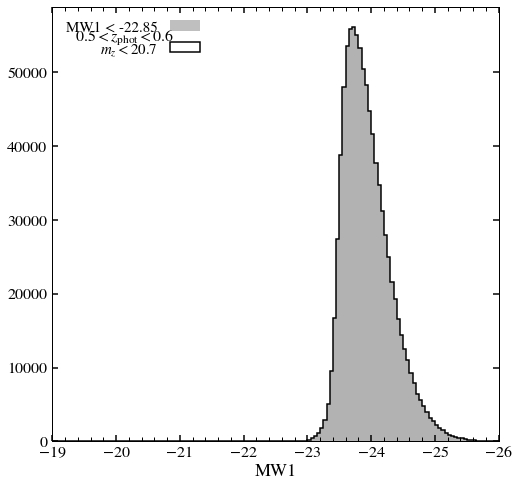

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

abs_mag_bins = np.round(np.arange(-26,-18+0.05,0.05),2)

ax.hist(t[band], bins=abs_mag_bins, color="gray", alpha=0.2, label="")
ax.hist(t[band], bins=abs_mag_bins[abs_mag_bins <= abs_mag_lim+0.05], color="gray", alpha=0.5, label=f"{band} < {abs_mag_lim}")
ax.hist(t[band], bins=abs_mag_bins, histtype="step", label="$m_z < 20.7$", color="k", lw=1.5)

ax.legend(markerfirst=False)
ax.set_xlim(-19,-26)
ax.set_xlabel(band)

ax.text(*get_corners(ax)["upper_left"], f"${zmin}$" + r"$< z_{\rm phot} <$" + f"$ {zmax}$", ha="left", va="top")

plt.show()


In [8]:
#-- grz DESI depth requirements: 24.0, 23.4, 22.5
#-- Rongpu reliable photo-z cut: apparent z-band mag < 21.0

#-- effective sample number density
areas = get_survey_area(masked=True) #-- (area_north_masked, area_south_masked)
area  = areas[0] if d=="north" else areas[1]

app_mags = t[band[1:]].data
abs_mags = t[band].data

if band=="Mz":
    app_mag_min = 22.50
else:
    app_mag_min = np.nanmax(app_mags)

print(f"{band[1:]}-band apparent magnitude min = {app_mag_min:.2f}")

#-- maximum possbile luminosity distance given magnitude and photometric redshift
dlum_Mpc_max = (10.**( -5. + ( app_mag_min - t[f"M{band[1:]}"] - t[f"K{band[1:]}"] )/5. )).data

zz = np.arange(0, 500, 0.01)
dlum_Mpc = cosmo.luminosity_distance(zz).value

#-- infer redshifts corresponding to these luminosity distances
z_of_dlum_Mpc = interpolate.interp1d(dlum_Mpc, zz, fill_value="extrapolate")

zphot = t["pz"].data

V_zphot  = (cosmo.comoving_volume(zphot) - cosmo.comoving_volume(zmin)).value
zmin_eff = zmin
zmax_eff = np.array([ np.min([ zmax,x ]) for x in z_of_dlum_Mpc(dlum_Mpc_max) ])
V_eff    = (cosmo.comoving_volume(zmax_eff) - cosmo.comoving_volume(zmin_eff)).value

abs_mag_hist,_ = np.histogram(t[band], bins=abs_mag_bins)
gal_counts     = np.cumsum(abs_mag_hist)

ng_eff = [np.sum( 1./(area*V_eff[t[band] < x]) ) for x in abs_mag_bins]

out = dict( abs_mag_bins=abs_mag_bins, ng_eff=ng_eff, gal_counts=gal_counts )

# out_fname = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy"
out_fname = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_LRG-opt.npy"
# out_fname = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_LRG-IR.npy"
print(f"Saving as {out_fname}...")
np.save(out_fname, out)


W1-band apparent magnitude min = 19.47
Saving as /Users/aberti/Desktop/research/desi_lrg_sham/data/stats/lum_func_MW1_z0p50-0p60_south_zmaglim20p7_LRG-opt.npy...


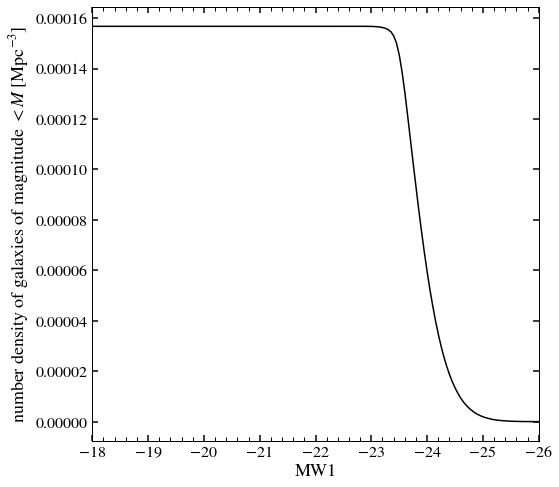

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ng_eff = lum_func_full["ng_eff"]

ax.plot(abs_mag_bins, ng_eff, color="black")

ax.set_xlim(-18,-26)
ax.set_xlabel(f"{band}")
ax.set_ylabel("number density of galaxies of magnitude $<M$ [Mpc$^{-3}$]")

# ax.semilogy()
# ax.set_ylim(1e-6,1e-2)
plt.show()


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# for this_band in ("Mz","MW1"):
#     this_lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{this_band}_{cat_tag}_{zmag_tag}_full.npy").item()
#     ax.plot(this_lum_func_full["abs_mag_bins"], lum_func_full["ng_eff"], label=this_band)

# ax.legend()
# ax.set_xlim(-26,-18)
# ax.set_xlabel("absolute magnitude $M_x$")
# ax.set_ylabel("number density of galaxies of magnitude $<M_x$ [Mpc$^{-3}$]")

# ax.text(*get_corners(ax)["lower_right"], f"${zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax}$", ha="right", va="bottom")

# plt.show()


<a class="anchor" id="load_halocat"></a>

# Create mock

## Load halo catalog

[BACK TO TOP](#outline)

In [10]:
%%time

################################
##  Load simulation snapshot  ##
################################

quiet = False

a = snaps["scale"][snaps["redshift"]==zsim][0]

halocat_fname = f"{SIMDIR}/{sim_tag}/CATALOGS/hlist_{str(a).replace('.','p')}0_mvir1e11.npy"

if os.path.exists( halocat_fname ):
    if not quiet:
        print(f"Loading {halocat_fname}...")
    halocat = Table( np.load(halocat_fname) )
    
halocat = halocat[np.log10(halocat["mvir"]) >= 11.5]

halocat.sort( sham_tag )

if (halocat[sham_tag][0] < halocat[sham_tag][-1]):
    halocat = halocat[::-1]

assert(halocat[sham_tag][0] > halocat[sham_tag][-1])


Loading /Users/aberti/Desktop/research/sims/mdpl2/CATALOGS/hlist_0p65650_mvir1e11.npy...
CPU times: user 23.5 s, sys: 11.3 s, total: 34.7 s
Wall time: 37.3 s


In [12]:
extra_halos_fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}_extra-halos.npy"

print(extra_halos_fname)

temp = Table(np.load(extra_halos_fname))


/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/zsnap0p52323_MW1limn22p85_extra-halos.npy


In [13]:
%%time

np.save(extra_halos_fname, vstack([temp, halocat[np.log10(halocat["mvir"]) < 11.5]]))


CPU times: user 11.1 s, sys: 17.9 s, total: 29 s
Wall time: 34.2 s


In [14]:
%%time

###################################################################
##  Infer halo number densities from target luminosity function  ##
###################################################################

sham_var = halocat[sham_tag]

#-- get value of nh = nh( sham_var ) for each value of sham_var

#-- halo number counts in bins of (log_)sham_var
H,_ = np.histogram( np.log10(sham_var), bins=sham_var_bins )

#-- cumulative halo abundance versus (min log_)sham_var
cdf_log_sham_var = np.max(np.cumsum(H))-np.cumsum(H)

#-- interpolation function for nh of (log_)sham_var
nh_of_log_sham_var = interpolate.interp1d(sham_var_cens,
                                          np.array(cdf_log_sham_var) / (vol_sim/(h**3)),
                                          fill_value="extrapolate")

#-- inferred cumulative halo number densities for sham_var values
nh_inferred = nh_of_log_sham_var( np.log10(sham_var) )

cname = "nh_inferred"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(nh_inferred, name=cname) )


CPU times: user 1.31 s, sys: 396 ms, total: 1.71 s
Wall time: 1.78 s


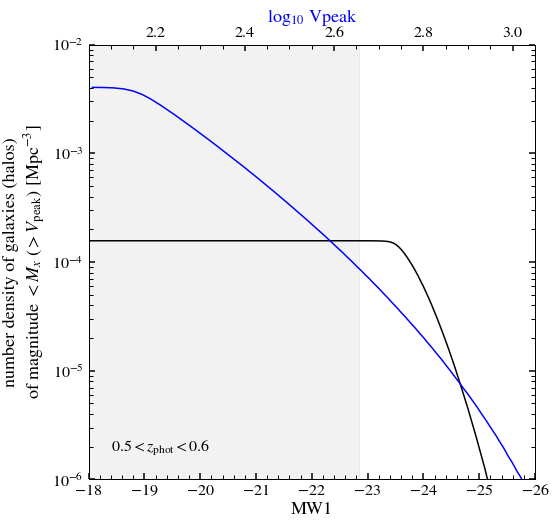

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.semilogy(lum_func_full["abs_mag_bins"], lum_func_full["ng_eff"], color="black")

ax.set_xlim(-18,-26)
ax.set_ylim(1e-6,1e-2)
ax.set_xlabel(f"{band}")
ax.set_ylabel("number density of galaxies (halos)\n" + r"of magnitude $<M_x$ ($>V_{\rm peak}$) [Mpc$^{-3}$]")

ax.fill_between((ax.get_xlim()[0],abs_mag_lim), ax.get_ylim()[-1]*np.ones(2), color="gray", alpha=0.1)

ax1 = ax.twiny()

ax1.plot(np.log10(sham_var)[::1], halocat["nh_inferred"][::1], color="blue")
# ax1.scatter(np.log10(sham_var)[::1000], halocat["nh_inferred"][::1000], color="blue", s=2)

ax1.set_xlim(2.05,3.05)
ax1.set_xlabel("$\log_{10}$ Vpeak", color="blue")

ax1.text(*get_corners(ax1, logy=True)["lower_left"], f"${zmin}$" + r"$< z_{\rm phot} <$" + f"$ {zmax}$", ha="left", va="bottom")

plt.show()


In [16]:
###################################################################################
##  Assign luminosities *without* scatter based on inferred halo number density  ##
###################################################################################

#-- get corresponding value of abs_mag for inferred nh values: abs_mag = abs_mag( ngal_eff=nh )
abs_mag_bins = np.round(lum_func_full["abs_mag_bins"],2)
ngal_eff     = lum_func_full["ng_eff"]

#-- interpolation function for abs_mag of ngal_eff
abs_mag_of_ngal_eff = interpolate.interp1d(ngal_eff, abs_mag_bins, fill_value="extrapolate")

nh_inferred      = halocat["nh_inferred"]
abs_mag_inferred = abs_mag_of_ngal_eff( nh_inferred )

#-- add inferred magnitudes (with MONOTONIC Vcirc correspondence) to halo catalog
cname = f"{band}_no_scatter"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred, name=cname) )

halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"] > np.max(abs_mag_bins)] = np.inf


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [17]:
mask = (halocat[f"{band}_no_scatter"] > -np.inf) # & (halocat[f"{band}_no_scatter"] < np.inf)

abs_mag_max = np.min(halocat[f"{band}_no_scatter"][mask])

# halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"] < abs_mag_max] = abs_mag_max


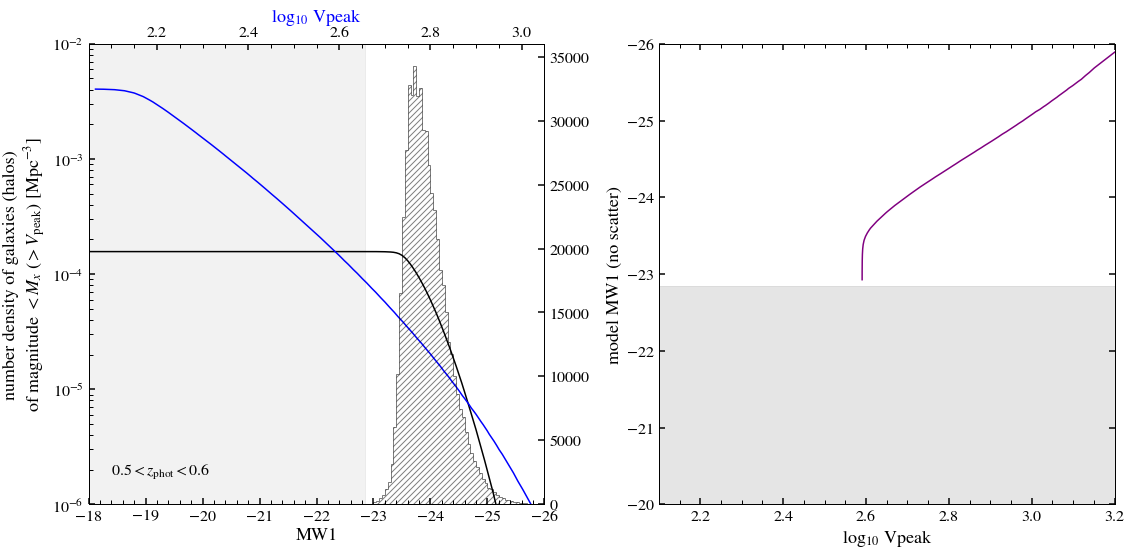

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

ax = axes[0]
ax.semilogy(lum_func_full["abs_mag_bins"], lum_func_full["ng_eff"], color="black")

ax.set_xlim(-18,-26)
ax.set_ylim(1e-6,1e-2)
ax.set_xlabel(f"{band}")
ax.set_ylabel("number density of galaxies (halos)\n" + r"of magnitude $<M_x$ ($>V_{\rm peak}$) [Mpc$^{-3}$]")
ax.fill_between((ax.get_xlim()[0],abs_mag_lim), ax.get_ylim()[-1]*np.ones(2), color="gray", alpha=0.1)

ax1 = ax.twiny()
ax1.plot(np.log10(sham_var)[::1000], halocat["nh_inferred"][::1000], color="blue")

ax1.set_xlim(2.05,3.05)
ax1.set_xlabel("$\log_{10}$ Vpeak", color="blue")
ax1.text(*get_corners(ax1, logy=True)["lower_left"], f"${zmin}$" + r"$< z_{\rm phot} <$" + f"$ {zmax}$", ha="left", va="bottom")

ax2 = ax.twinx()
ax2.hist(halocat[f"{band}_no_scatter"], bins=abs_mag_bins, histtype="step", color="k", hatch="////", alpha=0.5)

ax = axes[1]
ax.plot(np.log10(sham_var)[::100], halocat[f"{band}_no_scatter"][::100], color="purple")
# ax.scatter(np.log10(sham_var)[::100], halocat[f"{band}_no_scatter"][::100], s=2)

ax.set_xlim(2.1,3.2)
ax.set_ylim(-20,-26)
ax.set_xlabel("$\log_{10}$ Vpeak")
ax.set_ylabel(f"model {band} (no scatter)")
ax.fill_between(ax.get_xlim(),abs_mag_lim*np.ones(2), color="gray", alpha=0.2)

plt.tight_layout()

plt.show()


<a class="anchor" id="add_scatter"></a>

## Add scattered model magnitudes

[BACK TO TOP](#outline)

In [ ]:
# %%time

# #-- if adding to existing halocat with array of scattered magnitudes

# halocat_fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}.npy"

# print(f"Loading {halocat_fname}...")
# halocat = Table(np.load(halocat_fname))


In [19]:
%%time

nsig_clip = 2.5

for sigma_abs_mag in np.arange(0.05,0.71,0.05):
# sigma_abs_mag = 0.57

    cname_final = f"{band}_sig{str(np.round(sigma_abs_mag,2)).replace('.','p')}"
    # print(f"{now()} {cname_final}")
    if cname_final not in halocat.colnames:
        #-- add scatter to inferred magnitudes
        abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"], sigma_abs_mag)

        #-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
        #-- temporary column for intermediate SHAM step
        cname_temp = f"{band}_scattered"
        if cname_temp in halocat.colnames:
            halocat.remove_column( cname_temp )
        halocat.add_column( Column(abs_mag_inferred_scattered, name=cname_temp) )

        halocat.sort( cname_temp )

        abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
        abs_mag_inferred_sorted.sort()

        if cname_final in halocat.colnames:
            halocat.remove_column( cname_final )
        halocat.add_column( Column(abs_mag_inferred_sorted, name=cname_final) )
        

CPU times: user 2min 20s, sys: 20 s, total: 2min 40s
Wall time: 2min 46s


In [20]:
halocat

id,pid,upid,mvir,rvir,rs,x,y,z,vpeak,acc_scale,parent_mvir,nh_inferred,MW1_no_scatter,MW1_sig0p05,MW1_sig0p1,MW1_sig0p15,MW1_sig0p2,MW1_sig0p25,MW1_sig0p3,MW1_sig0p35,MW1_sig0p4,MW1_sig0p45,MW1_sig0p5,MW1_sig0p55,MW1_sig0p6,MW1_sig0p65,MW1_scattered,MW1_sig0p7
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9633630758,-1,-1,462350000000000.0,1781.590942,219.166,152.6405,789.62061,37.03614,1737.890015,0.6565,462350000000000.0,7.153945014614379e-09,-26.08496184619534,-26.122073567842854,-26.09143585431312,-25.83728280515666,-25.969887851809297,-25.95900049919052,-25.729179173809243,-25.757503074024353,-25.81487737988515,-26.039222895189813,-25.33912610268852,-25.524855186246707,-25.13143977282209,-24.49570167148567,-27.45860310254009,-26.17516766506956
9656326416,-1,-1,498350000000000.0,1826.688965,797.786011,348.63934,164.34155,426.22598,1479.540039,0.6565,498350000000000.0,4.7522982970553726e-08,-25.76590922849948,-25.780308848539107,-25.759839482816034,-25.922788363865983,-25.786182305178485,-25.772107187794823,-25.41945428206335,-25.795802490363315,-26.117316984090756,-25.76856509429798,-24.598522944254423,-25.840284666046145,-25.9699608837228,-24.667450587673873,-27.44052827645148,-26.17095625305192
9715246484,-1,-1,536470000000000.0,1872.119019,234.466995,766.45367,443.11404,522.60864,1614.040039,0.6565,536470000000000.0,1.8119311456522275e-08,-25.94626276228328,-25.966912399538206,-25.772107187794823,-25.969887851809297,-25.791923675464602,-26.079017499817926,-25.780603991573116,-25.68780130201581,-25.89487867682047,-26.12258102966452,-25.340097856072397,-26.16878707622671,-25.94626276228328,-24.136560058840953,-27.386574863461878,-26.169075422843346
9654653137,-1,-1,404490000000000.0,1703.94104,402.957001,330.97079,968.13501,542.94385,1390.380005,0.6565,404490000000000.0,9.111039727471368e-08,-25.64592151740607,-25.592103738293304,-25.659575806247776,-25.68414582167611,-25.504728148614163,-25.83010259709566,-25.752622429866005,-24.69959183810697,-25.54993406844964,-25.682900439593734,-25.390438817738456,-24.889757791653114,-25.075058306458935,-25.01271946077906,-27.3814360310663,-26.16878707622671
9713993437,-1,-1,1176400000000000.0,2432.238037,574.804016,753.29333,270.79126,347.09558,1972.609985,0.6565,1176400000000000.0,1.3208971279623693e-09,-26.15926170887593,-26.15926170887593,-26.16878707622671,-26.12258102966452,-25.956793521993596,-25.62139693604712,-26.122099227879133,-26.169075422843346,-25.8057093490759,-26.09143585431312,-25.47228682274915,-25.215387498446503,-25.120186116609833,-25.629739214150714,-27.380281206238774,-26.167481539622745
9712149154,-1,-1,416760000000000.0,1720.998047,454.321991,778.93146,68.30455,213.96452,1527.579956,0.6565,416760000000000.0,3.67246873564831e-08,-25.812091298972334,-25.832087808930456,-25.674549882182717,-25.840284666046145,-25.647141557066696,-25.914685820012544,-25.19243387788067,-25.441552927919137,-25.299405595643957,-24.60748211579417,-25.977221847164788,-25.710897266753854,-24.925817449484434,-25.006033942603388,-27.326685051749635,-26.160343544540012
9687371629,-1,-1,384150000000000.0,1674.880981,282.21701,596.02277,438.94653,985.60699,1360.25,0.6565,384150000000000.0,1.1169279503825766e-07,-25.600583280107067,-25.5894271069746,-25.597135714067626,-25.66282532121499,-25.438347962778813,-25.559513630632672,-25.76856509429798,-25.706180585569083,-25.049862387348426,-25.526747909226753,-25.825203175740306,-25.054193061391807,-24.62924007669999,-24.72986436099971,-27.322169136095678,-26.15926170887593
9683912284,-1,-1,856720000000000.0,2188.251953,339.390015,563.50604,105.58044,108.34573,1811.099976,0.6565,856720000000000.0,4.238406305240504e-09,-26.122099227879133,-26.139656198123397,-26.035418940049954,-26.125853230262663,-26.024591371458396,-25.770693235796447,-26.17095625305192,-26.12252972139

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4639: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':


/Users/aberti/Desktop/research/desi_lrg_sham/figures/vpeak_z0p50-0p60_MW1limn22p85.png


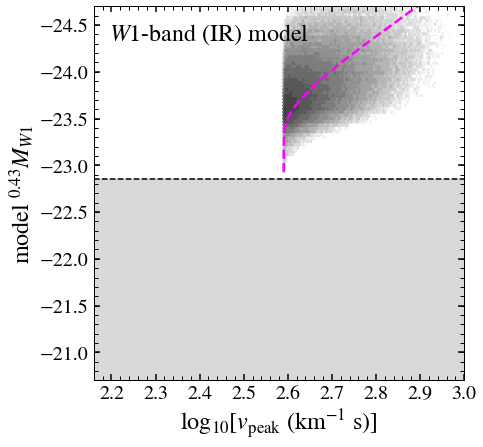

CPU times: user 4.4 s, sys: 1.86 s, total: 6.25 s
Wall time: 5.23 s


In [21]:
%%time

plt.rcParams["savefig.dpi"] = 200
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors

assert(cname_final in halocat.colnames)

fig, ax = plt.subplots(1, 1, figsize=(7,6.5))

ax.set_xlim(2.16,3.0)
ax.set_xticks(np.arange(2.2,3.01,0.1))
ylim = (-20.7,-24.2) if band=="Mz" else (-20.7,-24.7)
ax.set_ylim(ylim)

cmap = plt.get_cmap("binary")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(cmap, 0.0, 0.8)

DS = 1

bins = np.logspace(1.1,6,30)

X, Y = np.log10(halocat[sham_tag])[::DS], halocat[cname_final][::DS]
ax.hexbin(X, Y, gridsize=200, xscale="linear", yscale="linear", cmap=new_cmap, extent=(*ax.get_xlim(), *ax.get_ylim()[::-1]), bins=bins)

line_kwargs = dict(color="magenta", lw=2.5, ls="--")
X.sort()
v = halocat[f"{band}_no_scatter"][::DS].data.copy()
v.sort()
ax.plot(X, v[::-1], **line_kwargs)

# ax.legend( [Line2D([0], [0], **line_kwargs)], ["without scatter"], handletextpad=0.4, handlelength=2, fontsize=24, loc=4, borderpad=0.05)#, framealpha=0.9)
# ymin, ymax = ylim
# yt = ymin + 0.12*(ymax-ymin)
# ax.text(2.97, yt, r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=24)#, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

ax.set_xlabel(r"$\log_{10}[v_{\rm peak}\ ({\rm km}^{-1}\ {\rm s})]$", fontsize=24)
ylabel = r"${\rm model}\ ^{0.43}M_z$" if band=="Mz" else r"${\rm model}\ ^{0.43}M_{W1}$"
ax.set_ylabel(ylabel, fontsize=24)
ax.tick_params(axis="both", which="both", labelsize=20)

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.plot(ax.get_xlim(), abs_mag_lim*np.ones(2), color="k", ls="--")
ax.fill_between(ax.get_xlim(), abs_mag_lim*np.ones(2), color="k", alpha=0.15)

label = r"$z$-band (optical) model" if band=="Mz" else r"$W1$-band (IR) model"
ax.text(*get_corners(ax, margin=0.04)["upper_left"], label, ha="left", va="top", fontsize=24)

plt.tight_layout()

fname = f"{BASEDIR}/figures/vpeak_{cat_tag[:-6]}_{abs_mag_lim_tag}.png"
print(fname)

# plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# for sig in np.arange(1.20,0.0,-0.3):
#     cname = f"{band}_sig{str(np.round(sig,2)).replace('.','p')}"
#     if cname in halocat.colnames:
#         # print(cname)
#         # ax.scatter(np.log10(sham_var)[::100], halocat[f"{band}"][::100], s=2, alpha=0.5)
#         ax.scatter(np.log10(sham_var)[::100], halocat[cname][::100], s=2, alpha=0.5, label=cname)
# ax.scatter(np.log10(sham_var)[::1000], halocat[f"{band}_no_scatter"][::1000], s=2, color="white", label="none")

# ax.set_xlabel("$\log_{10}$ Vpeak")
# ax.set_ylabel(f"model {band}")

# ax.set_xlim(2.1,3.2)
# ax.set_ylim(-20,-26)

# for mm in abs_mag_bins_clust:
#     ax.plot(ax.get_xlim(),mm*np.ones(2), color="k")
# ax.fill_between(ax.get_xlim(),abs_mag_lim*np.ones(2), color="gray", alpha=0.4)

# plt.show()


In [ ]:
# save_as = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}.npy"
# print(f"Saving {save_as}...")

# np.save(save_as, halocat)
